<a href="https://colab.research.google.com/github/rifat01-rahman/Project-of-Python/blob/main/AR%2C_K_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Forecasting Models
We have used a traditional approach with ML intution to forecast the price variables. Our models is AR, K-fold which means-

**🔹 1. AR (Autoregressive) Model**

🧠 Concept:

An Autoregressive (AR) model predicts a variable using its own past values.

It assumes that the current value of a time series depends linearly on its previous values and a random error term.

**🔹 2. K-Fold Cross-Validation**

🧠 Concept:

K-Fold Cross-Validation is a model evaluation technique used to check how well a model generalizes to unseen data.

⚙️ How it works:

Split the dataset into K equal parts (folds).

For each iteration:

Use K–1 folds for training.

Use the remaining fold for testing.

Repeat the process K times, each time using a different fold as the test set.

Compute the average MSE or R² over all folds.

🧮 Example:

If
K=5:

You’ll train your model 5 times.

Each time, 4 folds for training, 1 for testing.

Final score = average of the 5 test results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_csv('/content/HHNGSP.csv')

In [ ]:
df.head()

,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [ ]:
df= df.rename(columns={'Date':'DATE', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'price'})

In [ ]:


if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # convert, invalid parsing -> NaT
    df = df.dropna(subset=['DATE'])  # drop invalid dates
    df_t = df.set_index('DATE').sort_index()
else:
    raise KeyError("Column 'DATE' not found in DataFrame")


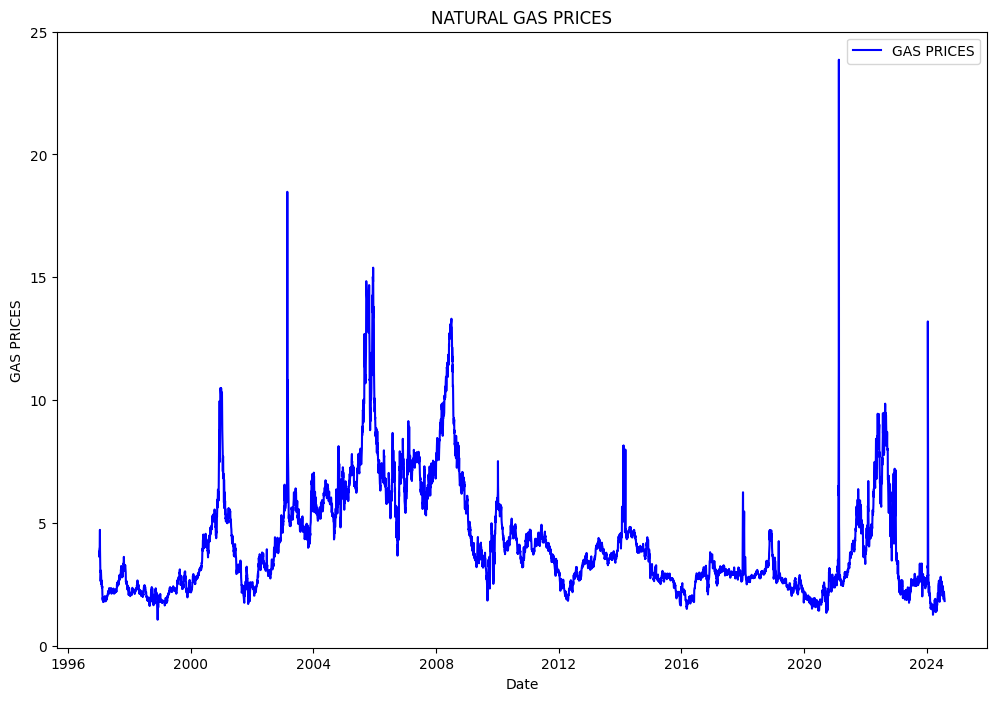

In [ ]:
def plot_timeseries(df_t: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    plt.plot(df_t.index, df_t['price'], label="GAS PRICES", color="blue")
    plt.title("NATURAL GAS PRICES")
    plt.xlabel("Date")
    plt.ylabel("GAS PRICES")

    plt.legend()
    plt.show()
plot_timeseries(df_t)

In [ ]:
data = df_t['price'].copy().reset_index(drop=True)

In [ ]:
def check_stationarity(series, signif=0.05):
    series = series.dropna()  # safety
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return p_value < signif, p_value

is_stationary, p_val = check_stationarity(data)
print(f"ADF p-value = {p_val:.4f} -> {'Stationary ✅' if is_stationary else 'Non-stationary ⚠️'}")
# Difference if not stationary
if not is_stationary:
    data_diff = data.diff().dropna()
    used_data = data_diff
    differenced = True
else:
    used_data = data.copy()
    differenced = False


ADF p-value = 0.0008 -> Stationary ✅


In [ ]:
import statsmodels.api as sm

max_lag = 12  # test up to 12 lags
bic_values = []

for lag in range(1, max_lag + 1):
    # Create lag matrix
    X_lag = pd.concat([used_data.shift(i) for i in range(1, lag + 1)], axis=1).dropna()
    y_lag = used_data.iloc[lag:]  # same length but might have misaligned index

    # Align shapes
    y_lag = y_lag.iloc[:len(X_lag)]

    model = sm.OLS(y_lag.values, sm.add_constant(X_lag.values)).fit()
    bic_values.append(model.aic)

best_lag = np.argmin(bic_values) + 1
print(f"✅ Optimal lag (by BIC): {best_lag}")


✅ Optimal lag (by BIC): 1


In [ ]:
# =========================================
# 2️⃣ CREATE LAG FEATURES (CLEAN & ALIGNED)
# =========================================

def create_lag_features(series, lags):
    """
    Create a DataFrame with the target variable (y)
    and its lag features up to the specified number of lags.

    Parameters:
        series (pd.Series): time series data
        lags (int): number of lag features to create

    Returns:
        pd.DataFrame: cleaned DataFrame with y and lag_i columns
    """
    df = pd.DataFrame({'y': series})

    # Create lag columns
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = series.shift(i)

    # Drop rows with NaNs caused by shifting
    df = df.dropna().reset_index(drop=True)

    return df

# Create lagged dataset
df_lag = create_lag_features(used_data, best_lag)

# Separate predictors and target
X = df_lag.drop(columns=['y']).to_numpy()
y = df_lag['y'].to_numpy()

print(f"Lagged DataFrame shape: {df_lag.shape}")
print(f"Features used: {list(df_lag.columns[1:])}")
print(df_lag.head())


Lagged DataFrame shape: (6928, 2)
Features used: ['lag_1']
      y  lag_1
0  3.80   3.82
1  3.61   3.80
2  3.92   3.61
3  4.00   3.92
4  4.01   4.00


In [ ]:
df_lag

,y,lag_1
1,3.80,3.82
2,3.61,3.80
3,3.92,3.61
4,4.00,3.92
5,4.01,4.00
...,...,...
6926,2.00,2.13
6927,2.00,2.00
6928,1.98,2.00
6929,1.90,1.98


In [ ]:
# Configuration
# -------------------------------
n_splits = 5                     # number of folds
test_size_ratio = 0.2            # 20% of total data
n_test = int(len(X) * test_size_ratio)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=n_test)

mse_scores = []        # for storing results
fold_predictions = []  # for visualization

# -------------------------------
# Cross-validation loop
# -------------------------------
for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # MSE calculation
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse  = mean_squared_error(y_test,  y_test_pred)

    mse_scores.append({
        'fold': fold,
        'train_mse': train_mse,
        'test_mse': test_mse
    })

    print(f"Fold {fold}: Train={len(train_index)} | Test={len(test_index)} | "
          f"Train MSE={train_mse:.4f} | Test MSE={test_mse:.4f}")

    # Store predictions for visualization
    fold_predictions.append(pd.DataFrame({
        'fold': fold,
        'actual': y_test,
        'predicted': y_test_pred,
        'index': test_index
    }))

# -------------------------------
# Summary and diagnostics
# -------------------------------
cv_results = pd.DataFrame(mse_scores)
print("\nCross-Validation MSE Summary:")
print(cv_results)

avg_train_mse = cv_results['train_mse'].mean()
avg_test_mse  = cv_results['test_mse'].mean()
gen_ratio = avg_test_mse / avg_train_mse

print(f"\nAverage Train MSE: {avg_train_mse:.4f}")
print(f"Average Test  MSE: {avg_test_mse:.4f}")
print(f"Generalization Ratio (Test/Train): {gen_ratio:.2f}")

Fold 1: Train=3 | Test=1385 | Train MSE=0.0074 | Test MSE=10.0847
Fold 2: Train=1388 | Test=1385 | Train MSE=0.0274 | Test MSE=0.2046
Fold 3: Train=2773 | Test=1385 | Train MSE=0.1156 | Test MSE=0.0277
Fold 4: Train=4158 | Test=1385 | Train MSE=0.0863 | Test MSE=0.0420
Fold 5: Train=5543 | Test=1385 | Train MSE=0.0752 | Test MSE=0.5189

Cross-Validation MSE Summary:
   fold  train_mse   test_mse
0     1   0.007400  10.084654
1     2   0.027368   0.204588
2     3   0.115630   0.027746
3     4   0.086336   0.041953
4     5   0.075239   0.518924

Average Train MSE: 0.0624
Average Test  MSE: 2.1756
Generalization Ratio (Test/Train): 34.87


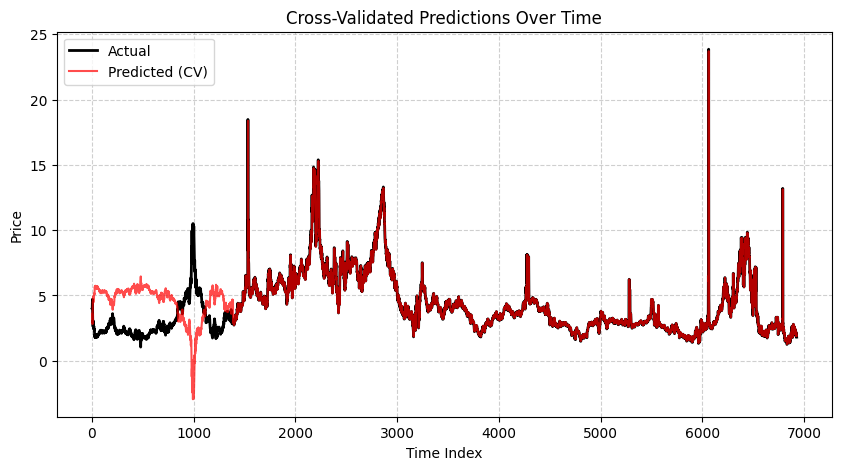

In [ ]:
# Visualization: CV Predictions
# -------------------------------
pred_df = pd.concat(fold_predictions).sort_values('index')

plt.figure(figsize=(10, 5))
plt.plot(pred_df['index'], pred_df['actual'], label='Actual', color='black', linewidth=2)
plt.plot(pred_df['index'], pred_df['predicted'], label='Predicted (CV)', color='red', alpha=0.7)
plt.title("Cross-Validated Predictions Over Time")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()